# 2D DPP conforming Galerkin FEM

Exploration notebook with all possible approaches, checking individually if the results are close to the exact solution.

In [1]:
import os
import matplotlib.pyplot as plt

os.environ["OMP_NUM_THREADS"] = "1"

import firedrake as fd

from perphil.forms.spaces import create_function_spaces
from perphil.forms.dpp import dpp_form, dpp_delayed_form
from perphil.mesh.builtin import create_mesh
from perphil.models.dpp.parameters import DPPParameters
from perphil.solvers.conditioning import (
    get_matrix_data_from_form,
    calculate_condition_number,
)
from perphil.solvers.solver import (
    solve_dpp,
    solve_dpp_nonlinear,
)
from perphil.solvers.parameters import (
    LINEAR_SOLVER_PARAMS,
    GMRES_PARAMS,
    FIELDSPLIT_LU_PARAMS,
    GMRES_ILU_PARAMS,
    PICARD_LU_SOLVER_PARAMS,
    PICARD_GMRES_SOLVER_PARAMS,
    PICARD_GMRES_ILU_SOLVER_PARAMS,
    PLAIN_GMRES_PARAMS,
)
from perphil.utils.plotting import plot_2d_mesh, plot_scalar_field, plot_vector_field
from perphil.utils.manufactured_solutions import interpolate_exact
from perphil.utils.postprocessing import (
    split_dpp_solution,
    calculate_darcy_velocity_from_pressure,
    slice_along_x,
)

For convenience, we define the operators from Firedrake:

In [2]:
grad = fd.grad
div = fd.div
dx = fd.dx
inner = fd.inner
pi = fd.pi
sin = fd.sin
exp = fd.exp
cos = fd.cos

## Case 1

### Mesh

In [3]:
mesh = create_mesh(10, 10, quadrilateral=True)

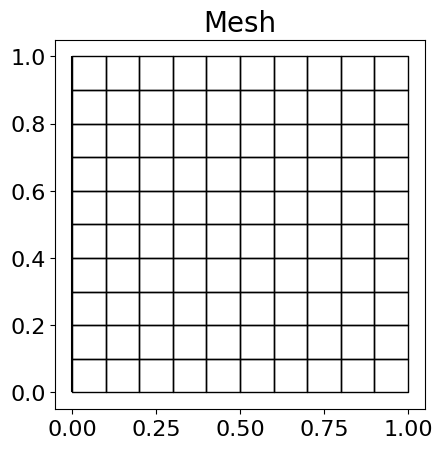

In [4]:
plot_2d_mesh(mesh)

### Exact solutions

In [5]:
U, V = create_function_spaces(
    mesh,
    velocity_deg=1,
    pressure_deg=1,
    velocity_family="CG",
    pressure_family="CG",
)

dpp_params = DPPParameters(k1=1.0, k2=1 / 1e2, beta=1.0, mu=1)
u1_exact, p1_exact, u2_exact, p2_exact = interpolate_exact(mesh, U, V, dpp_params)

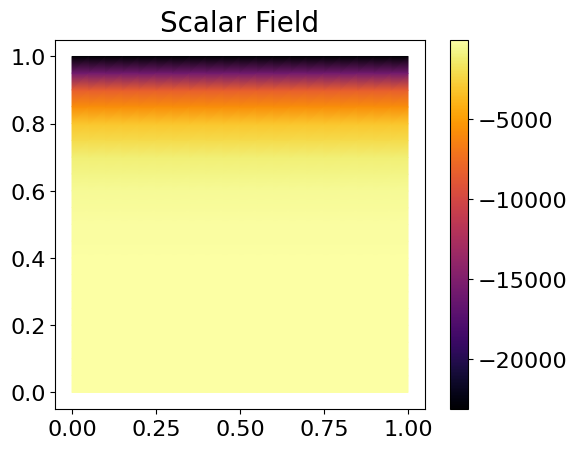

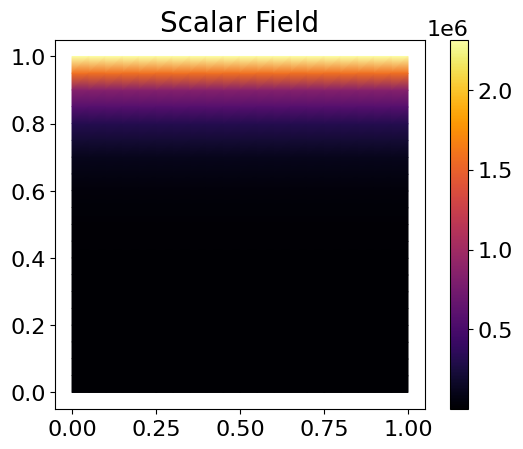

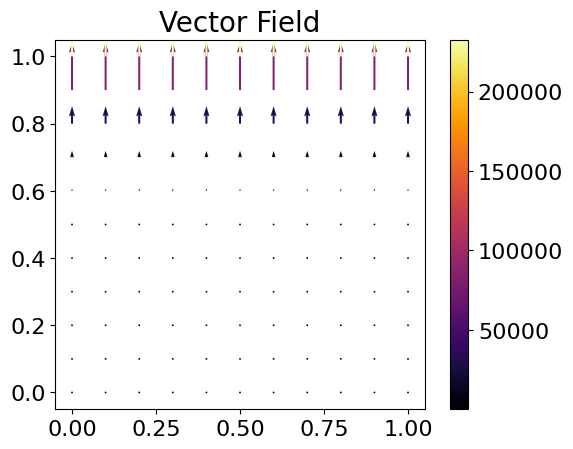

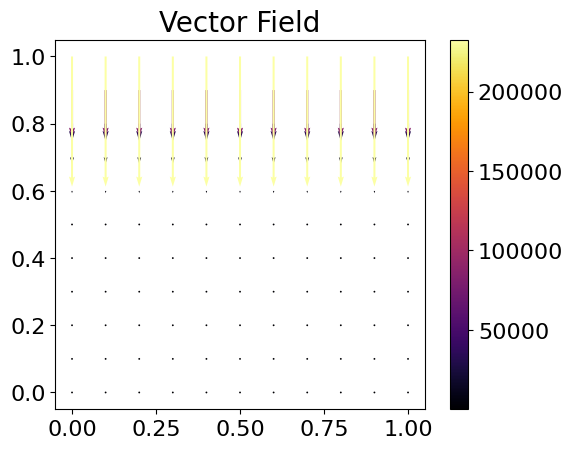

In [6]:
plot_scalar_field(p1_exact)
plot_scalar_field(p2_exact)
plot_vector_field(u1_exact)
plot_vector_field(u2_exact)

### Conforming Galerkin FEM approximations

#### Monolithic (fully coupled) approximation

In [7]:
W = V * V  # Mixed function space with both scales

# Dirichlet BCs
bc_macro = fd.DirichletBC(W.sub(0), p1_exact, "on_boundary")
bc_micro = fd.DirichletBC(W.sub(1), p2_exact, "on_boundary")
bcs = [bc_macro, bc_micro]

solver_parameters = LINEAR_SOLVER_PARAMS
solution_data_monolithic = solve_dpp(
    W, dpp_params, bcs, solver_parameters=solver_parameters
)
solution_monolithic = solution_data_monolithic.solution
p1_monolithic, p2_monolithic = split_dpp_solution(solution_monolithic)

u1_monolithic = calculate_darcy_velocity_from_pressure(p1_monolithic, dpp_params.k1)

u2_monolithic = calculate_darcy_velocity_from_pressure(p2_monolithic, dpp_params.k2)

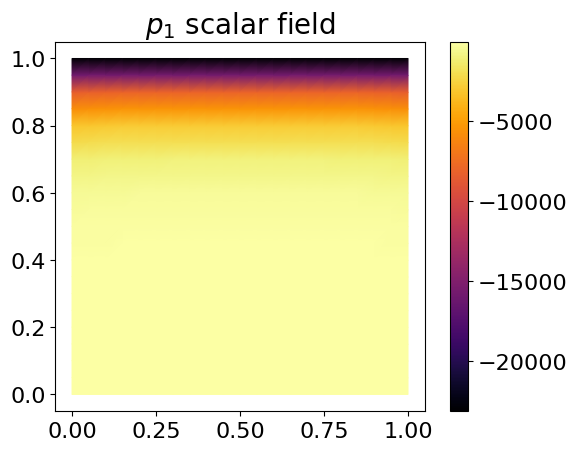

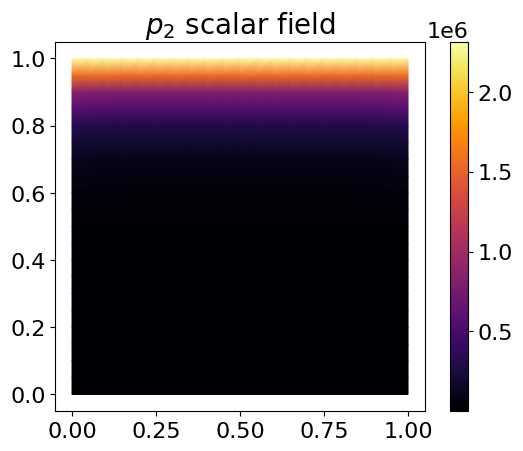

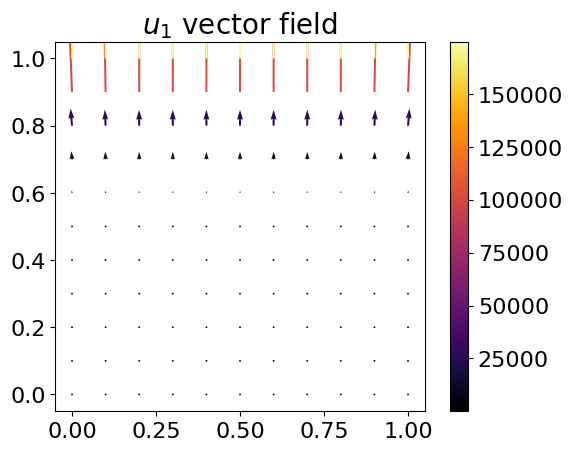

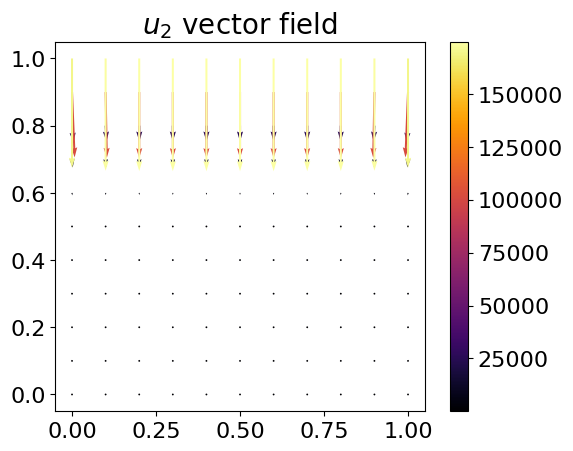

In [8]:
plot_scalar_field(p1_monolithic, title=r"$p_1$ scalar field")
plot_scalar_field(p2_monolithic, title=r"$p_2$ scalar field")
plot_vector_field(u1_monolithic, title=r"$u_1$ vector field")
plot_vector_field(u2_monolithic, title=r"$u_2$ vector field")

In [9]:
x_mid_point = 0.5
y_points, p1_mono_at_x_mid_point = slice_along_x(p1_monolithic, x_value=x_mid_point)
_, p1_exact_at_x_mid_point = slice_along_x(p1_exact, x_value=x_mid_point)
_, p2_mono_at_x_mid_point = slice_along_x(p2_monolithic, x_value=x_mid_point)
_, p2_exact_at_x_mid_point = slice_along_x(p2_exact, x_value=x_mid_point)

y_points, p1_mono_at_x_mid_point, p2_mono_at_x_mid_point

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([-1.00000000e+00, -1.49946480e+00, -4.38933558e+00, -1.36593392e+01,
        -4.08656173e+01, -1.19075697e+02, -3.42986552e+02, -9.83987764e+02,
        -2.81995567e+03, -8.08018988e+03, -2.31529069e+04]),
 array([1.00000000e+02, 1.97166457e+02, 5.28751291e+02, 1.48955743e+03,
        4.23188988e+03, 1.20603767e+04, 3.44439833e+04, 9.85224000e+04,
        2.82085384e+05, 8.08066208e+05, 2.31529069e+06]))

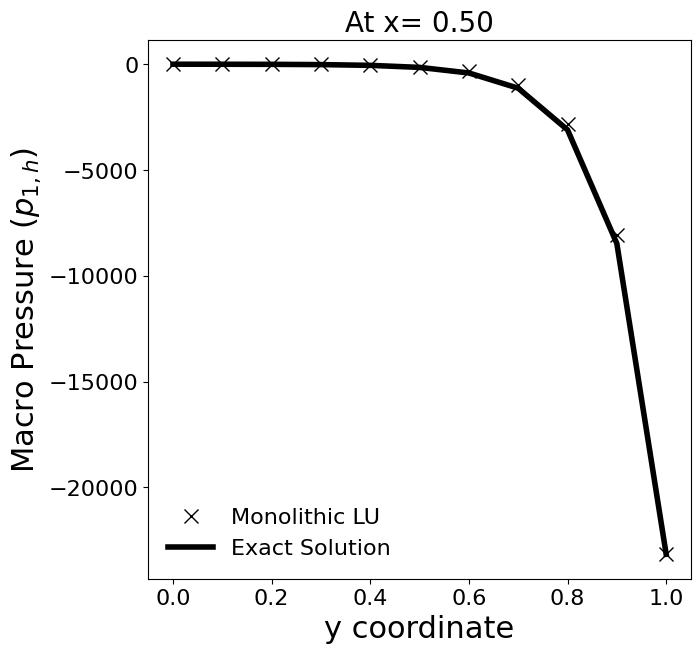

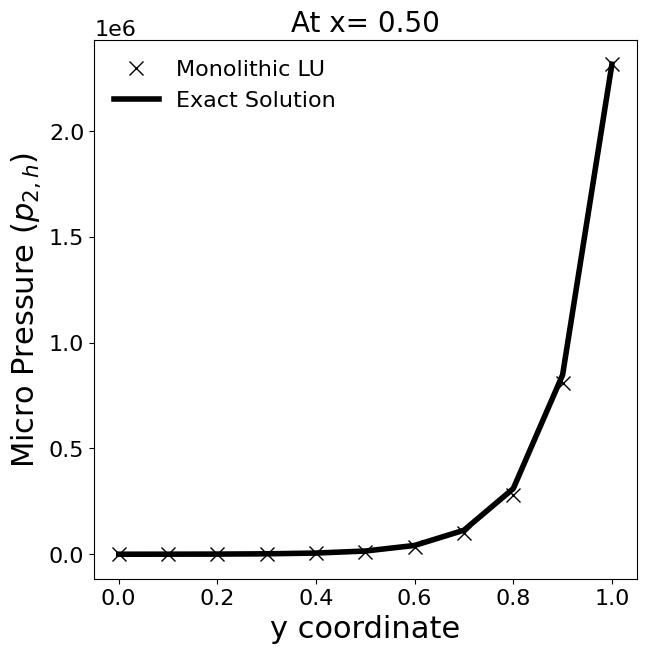

In [10]:
figsize = (7, 7)
plt.figure(figsize=figsize)
plt.plot(
    y_points, p1_mono_at_x_mid_point, "x", ms=10, lw=4, c="k", label="Monolithic LU"
)
plt.plot(y_points, p1_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Macro Pressure $(p_{1,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

plt.figure(figsize=figsize)
plt.plot(
    y_points, p2_mono_at_x_mid_point, "x", ms=10, lw=4, c="k", label="Monolithic LU"
)
plt.plot(y_points, p2_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Micro Pressure $(p_{2,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

#### Monolithic (fully coupled) approximation with plain GMRES

In [11]:
solver_additional_param = {
    "ksp_monitor": None,
    "snes_monitor": None,
    "snes_rtol": 1e-8,
    "snes_atol": 1e-12,
}
solver_parameters = {**PLAIN_GMRES_PARAMS, **solver_additional_param}
solution_data_monolithic_gmres = solve_dpp(
    W, dpp_params, bcs, solver_parameters=solver_parameters
)
solution_monolithic_gmres = solution_data_monolithic_gmres.solution
p1_gmres, p2_gmres = split_dpp_solution(solution_monolithic_gmres)

u1_gmres = calculate_darcy_velocity_from_pressure(p1_gmres, dpp_params.k1)

u2_gmres = calculate_darcy_velocity_from_pressure(p2_gmres, dpp_params.k2)

  0 SNES Function norm 8.485690809593e+04
    Residual norms for dpp_ solve.
    0 KSP Residual norm 8.485690809593e+04
    1 KSP Residual norm 6.424123551100e+04
    2 KSP Residual norm 5.973381712346e+04
    3 KSP Residual norm 5.719394646644e+04
    4 KSP Residual norm 5.417146148221e+04
    5 KSP Residual norm 4.927621914195e+04
    6 KSP Residual norm 4.224156323458e+04
    7 KSP Residual norm 3.406870829896e+04
    8 KSP Residual norm 2.672525000962e+04
    9 KSP Residual norm 1.953594596660e+04
   10 KSP Residual norm 1.785897445092e+04
   11 KSP Residual norm 1.480963857047e+04
   12 KSP Residual norm 1.299977620822e+04
   13 KSP Residual norm 1.253165986629e+04
   14 KSP Residual norm 1.213375830629e+04
   15 KSP Residual norm 1.109181708627e+04
   16 KSP Residual norm 7.040470065385e+03
   17 KSP Residual norm 4.206457177114e+03
   18 KSP Residual norm 4.042969821534e+03
   19 KSP Residual norm 3.944613697812e+03
   20 KSP Residual norm 2.952287913888e+03
   21 KSP Residual n

In [12]:
y_points, p1_gmres_at_x_mid_point = slice_along_x(p1_gmres, x_value=x_mid_point)
_, p2_gmres_at_x_mid_point = slice_along_x(p2_gmres, x_value=x_mid_point)

y_points, p1_gmres_at_x_mid_point, p2_gmres_at_x_mid_point

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([-1.00000000e+00, -1.49946482e+00, -4.38933560e+00, -1.36593393e+01,
        -4.08656174e+01, -1.19075697e+02, -3.42986552e+02, -9.83987765e+02,
        -2.81995567e+03, -8.08018988e+03, -2.31529069e+04]),
 array([1.00000000e+02, 1.97166457e+02, 5.28751290e+02, 1.48955743e+03,
        4.23188988e+03, 1.20603767e+04, 3.44439833e+04, 9.85224000e+04,
        2.82085384e+05, 8.08066208e+05, 2.31529069e+06]))

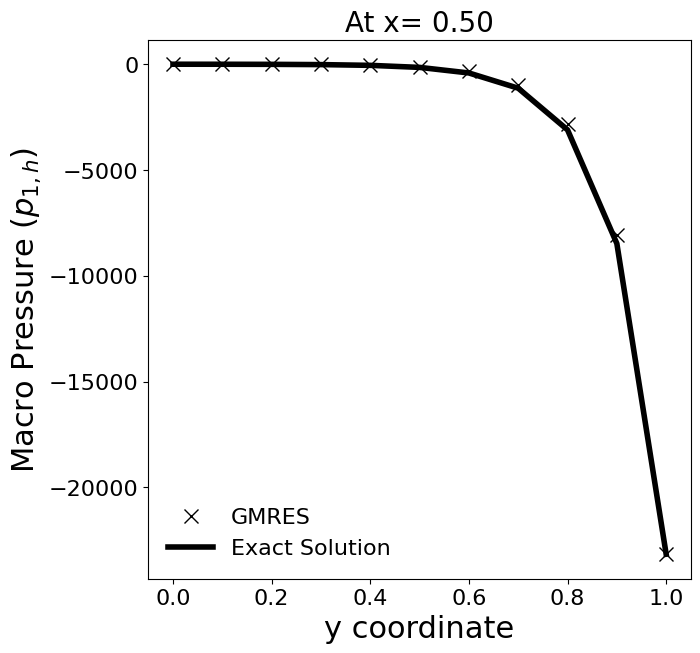

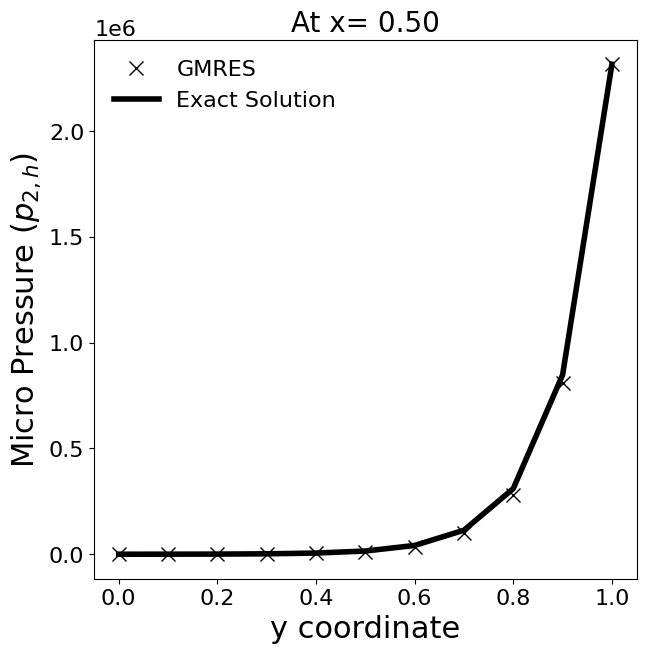

In [13]:
figsize = (7, 7)
plt.figure(figsize=figsize)
plt.plot(y_points, p1_gmres_at_x_mid_point, "x", ms=10, lw=4, c="k", label="GMRES")
plt.plot(y_points, p1_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Macro Pressure $(p_{1,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

plt.figure(figsize=figsize)
plt.plot(y_points, p2_gmres_at_x_mid_point, "x", ms=10, lw=4, c="k", label="GMRES")
plt.plot(y_points, p2_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Micro Pressure $(p_{2,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

#### Monolithic approximation with GMRES + ILU

In [14]:
solver_parameters = {**GMRES_ILU_PARAMS, **solver_additional_param}
solution_data_monolithic_gmres_ilu = solve_dpp(
    W, dpp_params, bcs, solver_parameters=solver_parameters
)
solution_monolithic_gmres_ilu = solution_data_monolithic_gmres_ilu.solution
p1_gmres_ilu, p2_gmres_ilu = split_dpp_solution(solution_monolithic_gmres_ilu)

u1_gmres_ilu = calculate_darcy_velocity_from_pressure(p1_gmres_ilu, dpp_params.k1)

u2_gmres_ilu = calculate_darcy_velocity_from_pressure(p2_gmres_ilu, dpp_params.k2)

  0 SNES Function norm 8.485690809593e+04
    Residual norms for dpp_ solve.
    0 KSP Residual norm 2.500673542910e+06
    1 KSP Residual norm 6.249746549991e+04
    2 KSP Residual norm 1.722924063135e+03
    3 KSP Residual norm 6.378077431109e+01
    4 KSP Residual norm 7.304251543972e+00
    5 KSP Residual norm 1.734893708425e+00
    6 KSP Residual norm 6.838604376744e-01
    7 KSP Residual norm 6.694765249472e-02
    8 KSP Residual norm 8.084456241843e-03
    9 KSP Residual norm 4.974535608622e-04
   10 KSP Residual norm 3.514280331679e-05
   11 KSP Residual norm 3.688641416004e-06
   12 KSP Residual norm 2.959510005609e-07
  1 SNES Function norm 2.197581166591e-07


In [15]:
y_points, p1_gmres_ilu_at_x_mid_point = slice_along_x(p1_gmres_ilu, x_value=x_mid_point)
_, p2_gmres_ilu_at_x_mid_point = slice_along_x(p2_gmres_ilu, x_value=x_mid_point)

y_points, p1_gmres_ilu_at_x_mid_point, p2_gmres_ilu_at_x_mid_point

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([-1.00000000e+00, -1.49946478e+00, -4.38933554e+00, -1.36593392e+01,
        -4.08656173e+01, -1.19075697e+02, -3.42986552e+02, -9.83987764e+02,
        -2.81995567e+03, -8.08018988e+03, -2.31529069e+04]),
 array([1.00000000e+02, 1.97166457e+02, 5.28751291e+02, 1.48955743e+03,
        4.23188988e+03, 1.20603767e+04, 3.44439833e+04, 9.85224000e+04,
        2.82085384e+05, 8.08066208e+05, 2.31529069e+06]))

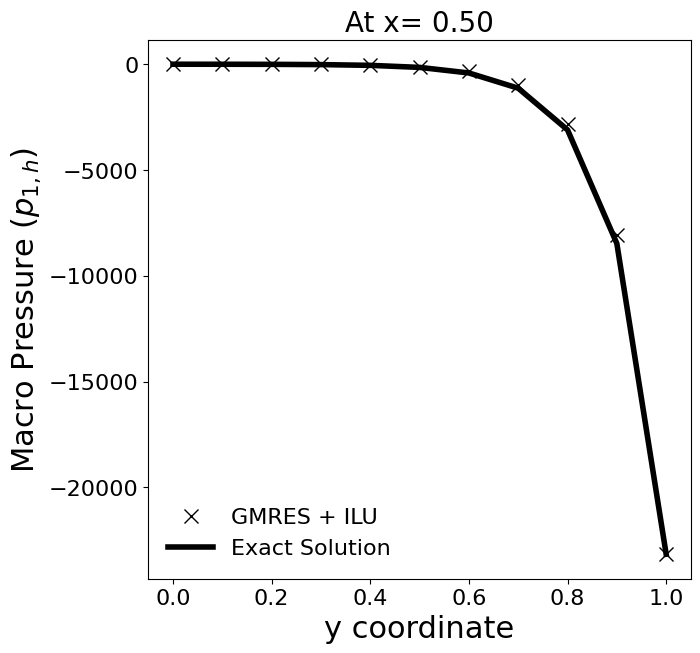

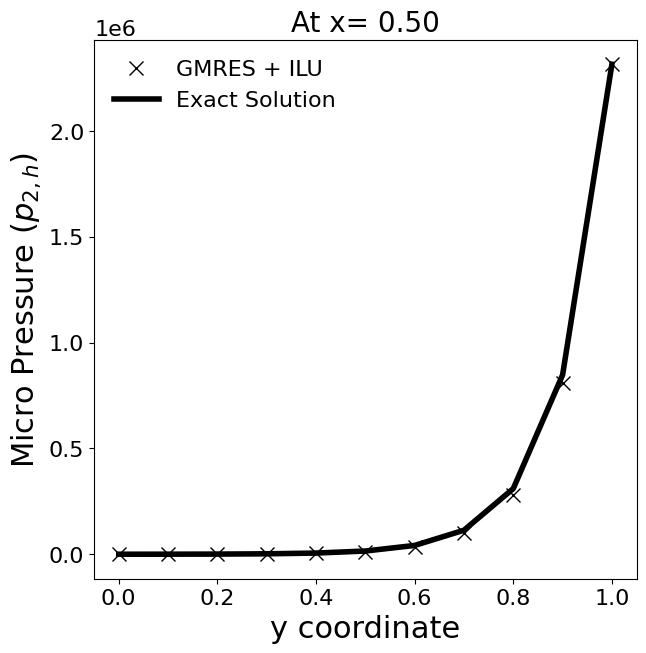

In [16]:
figsize = (7, 7)
plt.figure(figsize=figsize)
plt.plot(
    y_points, p1_gmres_ilu_at_x_mid_point, "x", ms=10, lw=4, c="k", label="GMRES + ILU"
)
plt.plot(y_points, p1_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Macro Pressure $(p_{1,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

plt.figure(figsize=figsize)
plt.plot(
    y_points, p2_gmres_ilu_at_x_mid_point, "x", ms=10, lw=4, c="k", label="GMRES + ILU"
)
plt.plot(y_points, p2_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Micro Pressure $(p_{2,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

#### Scale-splitting

Pre-conditioner by scale:

In [17]:
solver_parameters = {**GMRES_PARAMS, **FIELDSPLIT_LU_PARAMS, **solver_additional_param}
solution_data_monolithic_gmres = solve_dpp(
    W, dpp_params, bcs, solver_parameters=solver_parameters
)
solution_preconditioned = solution_data_monolithic_gmres.solution
p1_gmres, p2_preconditioned = split_dpp_solution(solution_preconditioned)

u1_preconditioned = calculate_darcy_velocity_from_pressure(p1_gmres, dpp_params.k1)

u2_preconditioned = calculate_darcy_velocity_from_pressure(
    p2_preconditioned, dpp_params.k2
)

  0 SNES Function norm 8.485690809593e+04
    Residual norms for dpp_ solve.
    0 KSP Residual norm 2.579294048667e+06
    1 KSP Residual norm 4.826558204558e+04
    2 KSP Residual norm 7.122478054650e+02
    3 KSP Residual norm 4.055258380528e+00
    4 KSP Residual norm 8.155414748172e-03
    5 KSP Residual norm 7.145565823259e-06
    6 KSP Residual norm 5.245017940560e-09
  1 SNES Function norm 9.135368710683e-09


In [18]:
solver_parameters = {
    **GMRES_ILU_PARAMS,
    **FIELDSPLIT_LU_PARAMS,
    **solver_additional_param,
}
solution_data_gmres_ilu = solve_dpp(
    W, dpp_params, bcs, solver_parameters=solver_parameters
)
solution_gmres_ilu = solution_data_gmres_ilu.solution
p1_gmres_ilu, p2_gmres_ilu = split_dpp_solution(solution_gmres_ilu)

u1_gmres_ilu = calculate_darcy_velocity_from_pressure(p1_gmres_ilu, dpp_params.k1)

u2_gmres_ilu = calculate_darcy_velocity_from_pressure(p2_gmres_ilu, dpp_params.k2)

  0 SNES Function norm 8.485690809593e+04
    Residual norms for dpp_ solve.
    0 KSP Residual norm 2.579294048667e+06
    1 KSP Residual norm 4.826558204558e+04
    2 KSP Residual norm 7.122478054650e+02
    3 KSP Residual norm 4.055258380528e+00
    4 KSP Residual norm 8.155414748172e-03
    5 KSP Residual norm 7.145565823259e-06
    6 KSP Residual norm 5.245017940560e-09
  1 SNES Function norm 9.135368710683e-09


In [19]:
y_points, p1_pc_at_x_mid_point = slice_along_x(p1_gmres, x_value=x_mid_point)
_, p2_pc_at_x_mid_point = slice_along_x(p2_preconditioned, x_value=x_mid_point)

y_points, p1_pc_at_x_mid_point, p2_pc_at_x_mid_point

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([-1.00000000e+00, -1.49946480e+00, -4.38933557e+00, -1.36593392e+01,
        -4.08656173e+01, -1.19075697e+02, -3.42986552e+02, -9.83987764e+02,
        -2.81995567e+03, -8.08018988e+03, -2.31529069e+04]),
 array([1.00000000e+02, 1.97166457e+02, 5.28751291e+02, 1.48955743e+03,
        4.23188988e+03, 1.20603767e+04, 3.44439833e+04, 9.85224000e+04,
        2.82085384e+05, 8.08066208e+05, 2.31529069e+06]))

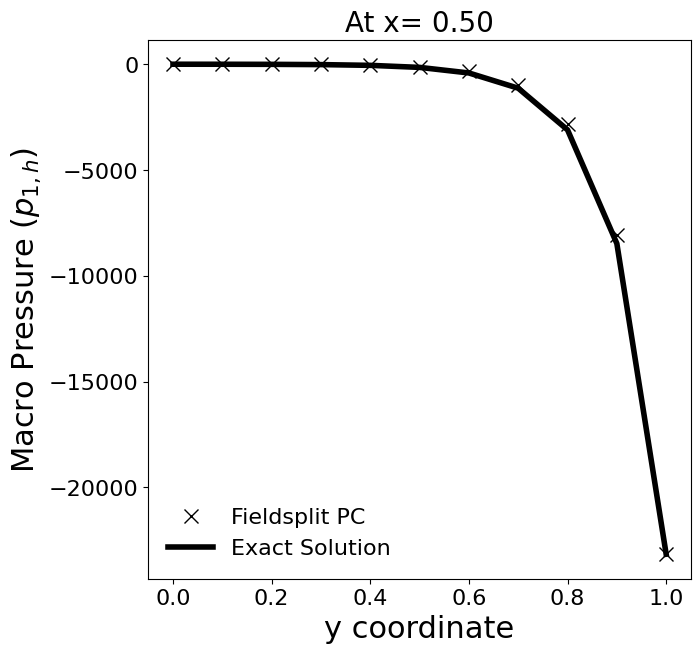

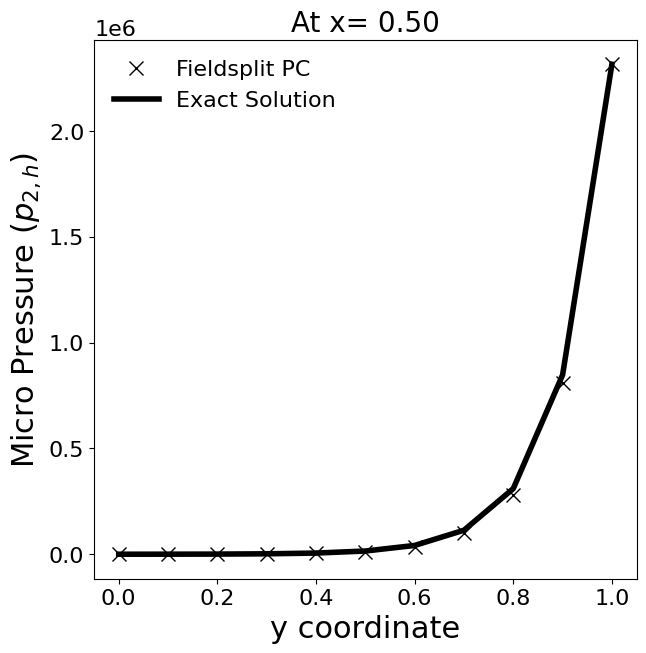

In [20]:
figsize = (7, 7)
plt.figure(figsize=figsize)
plt.plot(y_points, p1_pc_at_x_mid_point, "x", ms=10, lw=4, c="k", label="Fieldsplit PC")
plt.plot(y_points, p1_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Macro Pressure $(p_{1,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

plt.figure(figsize=figsize)
plt.plot(y_points, p2_pc_at_x_mid_point, "x", ms=10, lw=4, c="k", label="Fieldsplit PC")
plt.plot(y_points, p2_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Micro Pressure $(p_{2,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

Loop-based Picard fixed-point iterations using inner LU solver:

In [21]:
solver_parameters = {**PICARD_LU_SOLVER_PARAMS, **solver_additional_param}
solution_data_ngs = solve_dpp_nonlinear(
    W, dpp_params, bcs, solver_parameters=solver_parameters
)
solution_ngs = solution_data_ngs.solution
p1_picard, p2_picard = split_dpp_solution(solution_ngs)

u1_picard = calculate_darcy_velocity_from_pressure(p1_picard, dpp_params.k1)

u2_picard = calculate_darcy_velocity_from_pressure(p2_picard, dpp_params.k2)

  0 SNES Function norm 8.485690809593e+04
  1 SNES Function norm 2.046460224212e+04
  2 SNES Function norm 5.584382518230e+03
  3 SNES Function norm 1.846502296848e+03
  4 SNES Function norm 9.030727386571e+02
  5 SNES Function norm 5.982207459510e+02
  6 SNES Function norm 4.431849090876e+02
  7 SNES Function norm 3.389976613228e+02
  8 SNES Function norm 2.641975248049e+02
  9 SNES Function norm 2.097903406659e+02
 10 SNES Function norm 1.697462854385e+02
 11 SNES Function norm 1.396902943076e+02
 12 SNES Function norm 1.165538955869e+02
 13 SNES Function norm 9.826845739003e+01
 14 SNES Function norm 8.347082901642e+01
 15 SNES Function norm 7.126507511866e+01
 16 SNES Function norm 6.105279017784e+01
 17 SNES Function norm 5.242184881255e+01
 18 SNES Function norm 4.507705653323e+01
 19 SNES Function norm 3.879807152534e+01
 20 SNES Function norm 3.341409521232e+01
 21 SNES Function norm 2.878854549146e+01
 22 SNES Function norm 2.480958069687e+01
 23 SNES Function norm 2.138404343

In [22]:
y_points, p1_picard_at_x_mid_point = slice_along_x(p1_picard, x_value=x_mid_point)
_, p2_picard_at_x_mid_point = slice_along_x(p2_picard, x_value=x_mid_point)

y_points, p1_picard_at_x_mid_point, p2_picard_at_x_mid_point

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([-9.99998748e-01, -1.49968068e+00, -4.38971166e+00, -1.36598473e+01,
        -4.08662142e+01, -1.19076397e+02, -3.42987195e+02, -9.83988258e+02,
        -2.81995604e+03, -8.08019009e+03, -2.31529069e+04]),
 array([1.00000001e+02, 1.97166258e+02, 5.28750881e+02, 1.48955688e+03,
        4.23188922e+03, 1.20603761e+04, 3.44439827e+04, 9.85223994e+04,
        2.82085384e+05, 8.08066207e+05, 2.31529069e+06]))

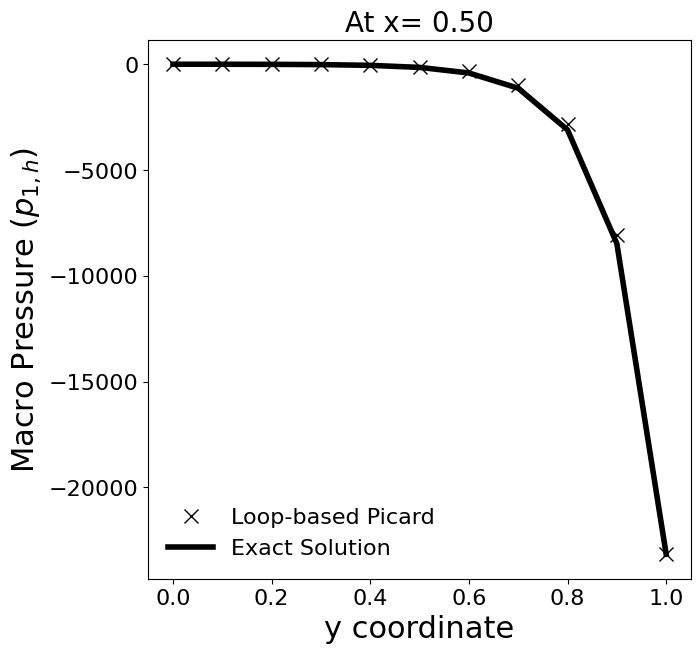

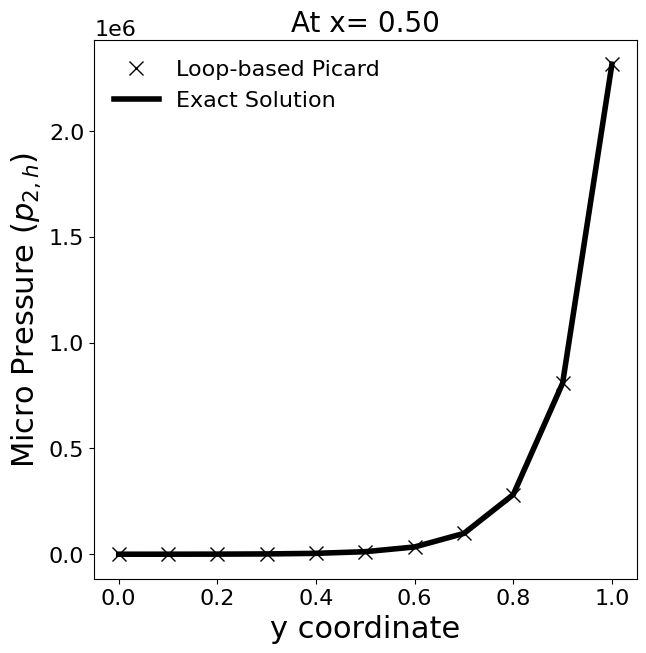

In [23]:
figsize = (7, 7)
plt.figure(figsize=figsize)
plt.plot(
    y_points,
    p1_picard_at_x_mid_point,
    "x",
    ms=10,
    lw=4,
    c="k",
    label="Loop-based Picard",
)
plt.plot(y_points, p1_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Macro Pressure $(p_{1,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

plt.figure(figsize=figsize)
plt.plot(
    y_points, p2_pc_at_x_mid_point, "x", ms=10, lw=4, c="k", label="Loop-based Picard"
)
plt.plot(y_points, p2_picard_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Micro Pressure $(p_{2,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

Loop-based Picard fixed-point iterations using inner GMRES solver:

In [24]:
solver_parameters = {**PICARD_GMRES_SOLVER_PARAMS, **solver_additional_param}
solution_data_picard_gmres = solve_dpp_nonlinear(
    W, dpp_params, bcs, solver_parameters=solver_parameters
)
solution_picard_gmres = solution_data_picard_gmres.solution
p1_picard_gmres, p2_picard_gmres = split_dpp_solution(solution_picard_gmres)

u1_picard_gmres = calculate_darcy_velocity_from_pressure(p1_picard_gmres, dpp_params.k1)

u2_picard_gmres = calculate_darcy_velocity_from_pressure(p2_picard_gmres, dpp_params.k2)

  0 SNES Function norm 8.485690809593e+04
  1 SNES Function norm 2.046460224212e+04
  2 SNES Function norm 5.584382518230e+03
  3 SNES Function norm 1.846502296848e+03
  4 SNES Function norm 9.030727386571e+02
  5 SNES Function norm 5.982207459510e+02
  6 SNES Function norm 4.431849090876e+02
  7 SNES Function norm 3.389976613228e+02
  8 SNES Function norm 2.641975248049e+02
  9 SNES Function norm 2.097903406659e+02
 10 SNES Function norm 1.697462854385e+02
 11 SNES Function norm 1.396902943076e+02
 12 SNES Function norm 1.165538955869e+02
 13 SNES Function norm 9.826845739003e+01
 14 SNES Function norm 8.347082901642e+01
 15 SNES Function norm 7.126507511866e+01
 16 SNES Function norm 6.105279017784e+01
 17 SNES Function norm 5.242184881255e+01
 18 SNES Function norm 4.507705653323e+01
 19 SNES Function norm 3.879807152534e+01
 20 SNES Function norm 3.341409521232e+01
 21 SNES Function norm 2.878854549146e+01
 22 SNES Function norm 2.480958069687e+01
 23 SNES Function norm 2.138404343

In [25]:
y_points, p1_picard_gmres_at_x_mid_point = slice_along_x(
    p1_picard_gmres, x_value=x_mid_point
)
_, p2_picard_gmres_at_x_mid_point = slice_along_x(p2_picard_gmres, x_value=x_mid_point)

y_points, p1_picard_gmres_at_x_mid_point, p2_picard_gmres_at_x_mid_point

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([-9.99998748e-01, -1.49968068e+00, -4.38971166e+00, -1.36598473e+01,
        -4.08662142e+01, -1.19076397e+02, -3.42987195e+02, -9.83988258e+02,
        -2.81995604e+03, -8.08019009e+03, -2.31529069e+04]),
 array([1.00000001e+02, 1.97166258e+02, 5.28750881e+02, 1.48955688e+03,
        4.23188922e+03, 1.20603761e+04, 3.44439827e+04, 9.85223994e+04,
        2.82085384e+05, 8.08066207e+05, 2.31529069e+06]))

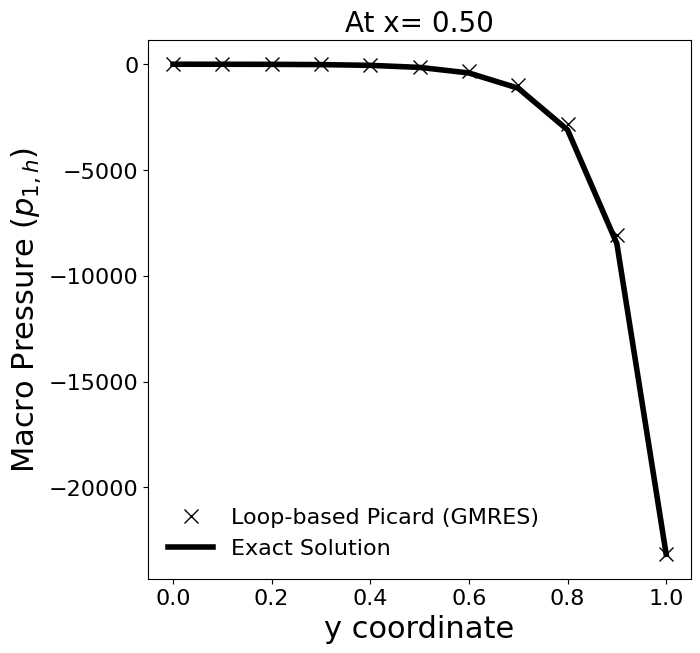

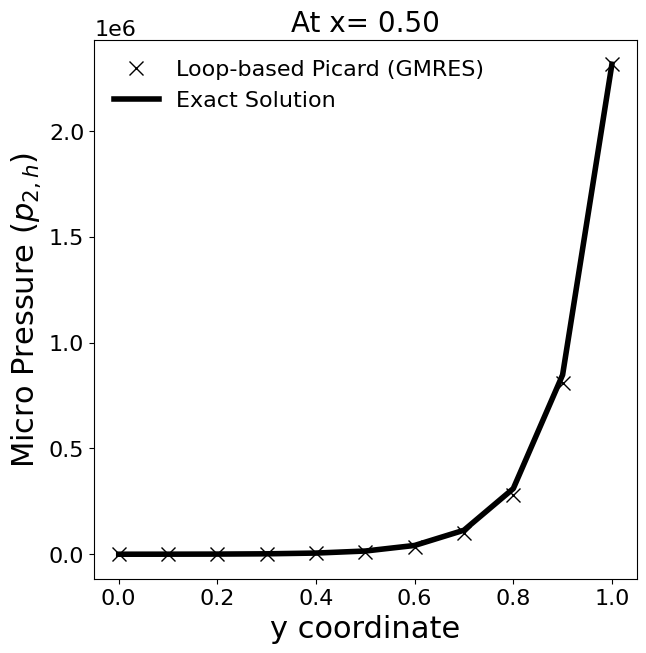

In [26]:
figsize = (7, 7)
plt.figure(figsize=figsize)
plt.plot(
    y_points,
    p1_picard_gmres_at_x_mid_point,
    "x",
    ms=10,
    lw=4,
    c="k",
    label="Loop-based Picard (GMRES)",
)
plt.plot(y_points, p1_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Macro Pressure $(p_{1,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

plt.figure(figsize=figsize)
plt.plot(
    y_points,
    p2_picard_gmres_at_x_mid_point,
    "x",
    ms=10,
    lw=4,
    c="k",
    label="Loop-based Picard (GMRES)",
)
plt.plot(y_points, p2_exact_at_x_mid_point, lw=4, c="k", label="Exact Solution")
plt.legend(frameon=False)
plt.xlabel("y coordinate")
plt.ylabel(r"Micro Pressure $(p_{2,h})$")
plt.title(f"At x= {x_mid_point:.2f}")
plt.show()

Loop-based Picard fixed-point iterations using inner GMRES + ILU solver:

In [27]:
solver_parameters = {**PICARD_GMRES_ILU_SOLVER_PARAMS, **solver_additional_param}
solution_data_picard_gmres_ilu = solve_dpp_nonlinear(
    W, dpp_params, bcs, solver_parameters=solver_parameters
)
solution_picard_gmres_ilu = solution_data_picard_gmres_ilu.solution
p1_picard_gmres_ilu, p2_picard_gmres_ilu = split_dpp_solution(solution_picard_gmres_ilu)

u1_picard_gmres_ilu = calculate_darcy_velocity_from_pressure(
    p1_picard_gmres_ilu, dpp_params.k1
)

u2_picard_gmres_ilu = calculate_darcy_velocity_from_pressure(
    p2_picard_gmres_ilu, dpp_params.k2
)

  0 SNES Function norm 8.485690809593e+04
  1 SNES Function norm 2.046460224212e+04
  2 SNES Function norm 5.584382518230e+03
  3 SNES Function norm 1.846502296848e+03
  4 SNES Function norm 9.030727386571e+02
  5 SNES Function norm 5.982207459510e+02
  6 SNES Function norm 4.431849090876e+02
  7 SNES Function norm 3.389976613228e+02
  8 SNES Function norm 2.641975248049e+02
  9 SNES Function norm 2.097903406659e+02
 10 SNES Function norm 1.697462854385e+02
 11 SNES Function norm 1.396902943076e+02
 12 SNES Function norm 1.165538955869e+02
 13 SNES Function norm 9.826845739003e+01
 14 SNES Function norm 8.347082901642e+01
 15 SNES Function norm 7.126507511866e+01
 16 SNES Function norm 6.105279017784e+01
 17 SNES Function norm 5.242184881255e+01
 18 SNES Function norm 4.507705653323e+01
 19 SNES Function norm 3.879807152534e+01
 20 SNES Function norm 3.341409521232e+01
 21 SNES Function norm 2.878854549146e+01
 22 SNES Function norm 2.480958069687e+01
 23 SNES Function norm 2.138404343

#### Conditioning Analysis

##### Monolithic system

In [28]:
monolithic_lhs_form, _ = dpp_form(W=W, model_params=dpp_params)
matrix_data = get_matrix_data_from_form(monolithic_lhs_form, boundary_conditions=bcs)
monolithic_system_condition_number = calculate_condition_number(
    matrix_data.sparse_csr_data,
    num_of_factors=matrix_data.number_of_dofs - 1,
)
print(f"Monolithic system Condition Number: {monolithic_system_condition_number}")

Monolithic system Condition Number: 348.8128903551021


##### Scale-splitting

In [29]:
# Prepare initial zero estimates for pressures
p1_zero = fd.Function(V)
p1_zero.interpolate(fd.Constant(0.0))
p2_zero = fd.Function(V)
p2_zero.interpolate(fd.Constant(0.0))

# Build bilinear forms for scale-splitting
forms_macro, forms_micro = dpp_delayed_form(V, V, dpp_params, p1_zero, p2_zero)
a_macro_form, _ = forms_macro
a_micro_form, _ = forms_micro

# Create BCs for macro and micro in individual spaces
bc_macro_V = fd.DirichletBC(V, p1_exact, "on_boundary")
bc_micro_V = fd.DirichletBC(V, p2_exact, "on_boundary")

# Conditioning analysis for the macro system
matrix_data_macro = get_matrix_data_from_form(a_macro_form, [bc_macro_V])
macro_condition_number = calculate_condition_number(
    matrix_data_macro.sparse_csr_data,
    num_of_factors=matrix_data_macro.number_of_dofs - 1,
)
print(f"Macro system Condition Number: {macro_condition_number}")

# Conditioning analysis for the micro system
matrix_data_micro = get_matrix_data_from_form(a_micro_form, [bc_micro_V])
micro_condition_number = calculate_condition_number(
    matrix_data_micro.sparse_csr_data,
    num_of_factors=matrix_data_micro.number_of_dofs - 1,
)
print(f"Micro system Condition Number: {micro_condition_number}")

Macro system Condition Number: 19.16437906256952
Micro system Condition Number: 86.19076137224923
